# Katz centrality and Google's PageRank

## Google's PageRank

In [24]:
#import libraries
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer
import pandas as pd

For simplicity we will not take directed graphs but rather undirected and then assume that every edge points in both directions.

In [2]:
#computing adjacency matrix, belonging to graph G and H
G = nx.barabasi_albert_graph(5,1) 
H = nx.complete_graph(100)
M = nx.adjacency_matrix(G)
N = nx.adjacency_matrix(H)
#print(M.todense())

### Algorithm 
#### General model
1. generate network
2. find square "adjacency matrix" Q that belongs to selected network: <br>
     (i,j) = 1/(#outlinks of j) ; if there exists a link from j to i <br>
     (i,j) = 0 ; otherwise <br>
The sum of every column should be 1. <br>
3. use power method for finding eigenvector r <br>
     for k=1,2... until convergence: <br>
        r^(k) = Q*r^(k-1)

In [3]:
def Qmatrix(matrix):
    '''for given adjecency matrix returns column stohastic matrix Q'''
    sums = np.sum(matrix, axis=0)        #array of sums of columns in matrix
    return np.nan_to_num(matrix/sums)                   #divide every column with its sum

def pagerank1(matrix, max_num_of_steps, tolerance):
    '''returns pagerank vector of matrix, 
    warning: do not use this function when #(nodes) * max_num_of_steps >> 1000003'''
    start = timer()
    Q = Qmatrix(matrix)           #column stohastic matrix from given matrix
    r = Q[:,0]                    #first guess for vector r is first column of Q 
    diff = 1000 
    k = 0 
    while diff > tolerance and k < max_num_of_steps:
        r, q = Q.dot(r), r               #inner product of matrix Q and vector r
        #r = q/np.linalg.norm(q, ord=1)  #not necessary
        diff = np.linalg.norm(q-r, ord=1)
        k+=1
    print('process finished after {} iterations'.format(k))
    end = timer()
    print('time consumption: {} seconds'.format(end-start))  #timing of the process
    return r

First, we check if the function pagerank1 works correctly. We use it on complete graph, where we know what is the correct pagerank vector. 
We will compare how size of graph (number of nodes and edges), prescribed maximum number of steps, inclusion of normalizing the vector and different first guesses for vector r affect time consumption of iteration and precision of pagerank vector.  

In [4]:
pagerank1(N, 1000, 0.001)
pagerank1(N, 10, 0.001)

process finished after 2 iterations
time consumption: 0.0990882961585618 seconds
process finished after 2 iterations
time consumption: 0.0011867245930817644 seconds


matrix([[ 0.00999898],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0.01000001],
        [ 0

With enough number of steps we get the right result, so pagerank1 works correctly. 
Now we use it on barabasi albert graph.

In [5]:
Qmatrix(M)
#pagerank1(M, 1000, 0)
pagerank1(M, 10, 0.1)
#Qmatrix(M) (different result if with norm of vector r)

process finished after 10 iterations
time consumption: 0.01884903537465646 seconds


matrix([[ 0.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 0.]])

Ranking says that some pages are not important at all. For better intuition lets take a look at this graph.

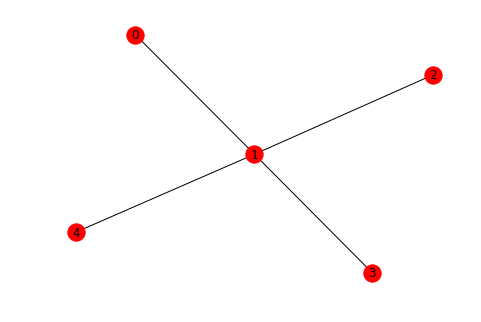

In [6]:
nx.draw(G, with_labels=True)
plt.show()

#### Adjusted model
1. generate network
2. find matrix Q and then adjust it: every zero column should have constant values in all places: <br>
    d[j] = 1 ; if #(outlinks of j) = 0 <br>
    d[j] = 0 ; otherwise <br>
    e = [1 ... 1]^T <br>
    => P = Q + 1/n*e*d^t <br>
    => A =  α*P + (1- α)/n*e*e^T, where 0 <= α <=1 <br>
3. use power method for finding r <br>
    for k=1,2... until convergence: <br>
        r^(k) = A*r^(k-1)

In [7]:
def Qmatrix(matrix):
    '''for given adjecency matrix of a network returns column stohastic matrix Q,
    some columns may still be zero'''
    sums = np.sum(matrix, axis=0)       #array of sums of columns in matrix
    return np.nan_to_num(matrix/sums)   #divide every column with it's sum, if sum is 0,  
                                        #returns zero column instead of nan

def dvector(matrix):
    '''for given adjecency matrix returns transposed vector d, where d[j] = 1 ; if #(outlinks of j) = 0 
    and d[j] = 0 ; otherwise'''
    Q = Qmatrix(matrix)             #compute matrix Q
    sums = np.sum(matrix, axis=0)   #array of sums of columns in matrix 
    d_bool = (sums == 0)            #booleninan array, True if the sum of a column is equal to 0, false otherwise
    d = d_bool*1                    #convert False to 0 and True to 1
    return d

def evector(n):
    '''returns vector v of ones in size of n''' # n = num of columns in matrix
    return np.ones((n,1))    

def Pmatrix(matrix):
    '''returns column stohastic matrix P without zero columns'''
    n = matrix.shape[1]
    Q = Qmatrix(matrix)
    e = evector(n)
    d = dvector(matrix)
    return Q + 1/n*e.dot(d)

def Amatrix(matrix, alpha):
    '''returns ireducible column stohastic matrix A of given matrix, 
    where 0 <= alpha <= 1'''
    n = matrix.shape[1]
    e = evector(n)
    P = Pmatrix(matrix)
    return alpha*P + (1-alpha)*1/n*e.dot(e.transpose())

def pagerank2(matrix, max_num_of_steps, tolerance, alpha):
    '''returns pagerank vector of adjacency matrix, 0<=alpha<=1'''
    start = timer()
    A = Amatrix(matrix, alpha)           #column stohastic matrix from given matrix
    r = A[:,0]  #first guess for vector r is first column of Q
    diff = 1000
    k = 0
    while diff > tolerance and k < max_num_of_steps:
        r, q = A.dot(r), r              #inner product of matrix Q and vector r
        #r = q/np.linalg.norm(q, ord=1)  #not necessary
        diff = np.linalg.norm(q-r, ord=1)
        k+=1
    print('process finished after {} iterations'.format(k))
    end = timer()
    print('time consumption: {} seconds'.format(end-start))  #timing of the process
    return r

Let's see how every one of these functions works and what output they produce. <br>
Firstly, let's take a look at adjacency matrix of directed graph $T$:

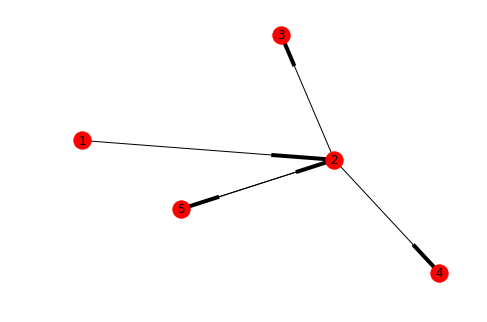

[[0 1 0 0 0]
 [0 0 1 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]]


In [8]:
T = nx.DiGraph()   # or DiGraph, etc
T.add_edges_from( ((1,2), (2,3), (2,4), (2,5), (5,2)) )
nx.draw(T, with_labels=True)
plt.show()
R = nx.adjacency_matrix(T)
print(R.todense())

First column of $R$ is a zero column and general pagerank (pagerank1) does not work well in these cases. Now we compute column stohastic matrix Q with *Qmatrix* function. Zero column will not change in this process.

In [9]:
Qmatrix(R)

C:\Users\Anamari\Anaconda3\lib\site-packages\scipy\sparse\base.py:484: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


matrix([[ 0. ,  0.5,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  1. ,  1. ,  1. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0.5,  0. ,  0. ,  0. ]])

That zero column could be a problem. It means that random surfer in this network could get stuck in that web page. We replace zeros with equal constant values in all places. For that we use the *Pmatrix* function. 

In [10]:
Pmatrix(R)

C:\Users\Anamari\Anaconda3\lib\site-packages\scipy\sparse\base.py:484: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


matrix([[ 0.2,  0.5,  0. ,  0. ,  0. ],
        [ 0.2,  0. ,  1. ,  1. ,  1. ],
        [ 0.2,  0. ,  0. ,  0. ,  0. ],
        [ 0.2,  0. ,  0. ,  0. ,  0. ],
        [ 0.2,  0.5,  0. ,  0. ,  0. ]])

Zero column was replaced by 0.2 in all places. Now we have a real column stohastic matrix. <br>
Next, we want to have irreducible matrix, which due to the size of the web, we usually do not have. For that purpuse we add links from and to all pages with *Amatrix* function.   


In [11]:
Amatrix(R, 0.98)

C:\Users\Anamari\Anaconda3\lib\site-packages\scipy\sparse\base.py:484: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


matrix([[ 0.2  ,  0.494,  0.004,  0.004,  0.004],
        [ 0.2  ,  0.004,  0.984,  0.984,  0.984],
        [ 0.2  ,  0.004,  0.004,  0.004,  0.004],
        [ 0.2  ,  0.004,  0.004,  0.004,  0.004],
        [ 0.2  ,  0.494,  0.004,  0.004,  0.004]])

In [12]:
pagerank2(R,10000000,0.001, 0.99)

process finished after 12 iterations
time consumption: 0.008048344807855434 seconds


C:\Users\Anamari\Anaconda3\lib\site-packages\scipy\sparse\base.py:484: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


matrix([[ 0.2489753 ],
        [ 0.39941354],
        [ 0.05131793],
        [ 0.05131793],
        [ 0.2489753 ]])

C:\Users\Anamari\Anaconda3\lib\site-packages\scipy\sparse\base.py:484: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


process finished after 49 iterations
time consumption: 0.010825494179917738 seconds


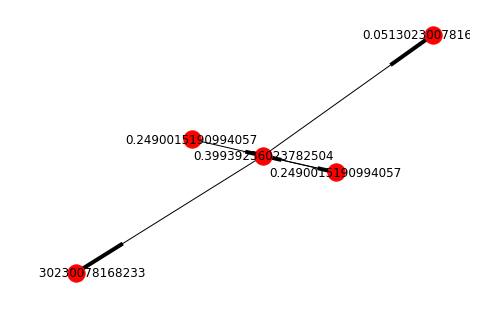

0.2490015190994057

In [13]:
#pagerank on graph
from itertools import chain
r = pagerank2(R,100,0, 0.99) 
keys = list(range(1, r.shape[0]+2))
values = list(chain.from_iterable(r.tolist()))
t = {k: v for k, v in zip(keys, values)}
#t
nx.set_node_attributes(T, t, 'pagerank')
nx.draw(T, with_labels=True, labels = t, with_attributes=True)
plt.show()
T.node[1]['pagerank']

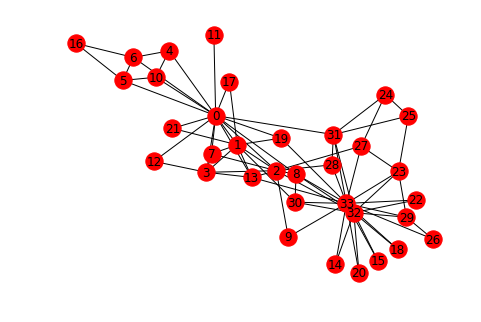

In [14]:
# pagerank on bigger network
O = nx.karate_club_graph() 
nx.draw(O, with_labels=True)
plt.show()
#R = nx.adjacency_matrix(T)
#print(R.todense())

In [15]:
#citation:@misc{snapnets,
#  author       = {Jure Leskovec and Andrej Krevl},
#  title        = {{SNAP Datasets}: {Stanford} Large Network Dataset Collection},
#  howpublished = {\url{http://snap.stanford.edu/data}},
#  month        = jun,
#  year         = 2014
#}
G_fb = nx.read_edgelist('facebook_combined.txt')

In [16]:
print(nx.info(G_fb))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


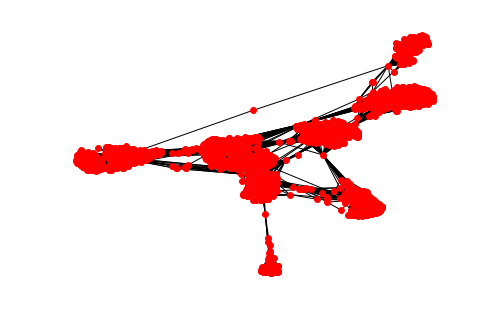

In [17]:
spring_pos = nx.spring_layout(G_fb)
nx.draw(G_fb, pos = spring_pos, node_size = 35)
#plt.savefig("Facebook_graph.png", format="PNG")
plt.show()

In [18]:
M_fb = nx.adjacency_matrix(G_fb)
r_1 = pagerank2(M_fb,10000000,0.0000001, 0.98)
print(r_1)

process finished after 575 iterations
time consumption: 11.775641055795717 seconds
[[  4.79508113e-03]
 [  2.17910466e-04]
 [  1.52316417e-04]
 ..., 
 [  6.77736016e-05]
 [  1.25649865e-04]
 [  2.72346363e-04]]


In [39]:
pagerank2(M_fb,10000000,0.0000001, 0.01)

process finished after 4 iterations
time consumption: 3.715699313379446 seconds


matrix([[ 0.00039399],
        [ 0.00024719],
        [ 0.00024658],
        ..., 
        [ 0.00024578],
        [ 0.00024585],
        [ 0.00024747]])

In [33]:
r_3 = pagerank2(M_fb,10000000,0.0000001, 0.5)

process finished after 23 iterations
time consumption: 4.623708095422444 seconds


In [30]:
r_2 = pagerank2(M_fb,10000000,0.0000001, 0.999)
print(r_2)

process finished after 4719 iterations
time consumption: 61.73710875091092 seconds
[[  2.37207123e-03]
 [  1.15387662e-04]
 [  6.99886732e-05]
 ..., 
 [  2.37766591e-05]
 [  4.70770334e-05]
 [  1.04002744e-04]]


In [36]:
r_4 = pagerank2(M_fb,10000000,0.0000001, 0.9999)
print(r_4)

process finished after 8104 iterations
time consumption: 105.30294071864228 seconds
[[  1.99799361e-03]
 [  9.77897213e-05]
 [  5.77554403e-05]
 ..., 
 [  1.28541957e-05]
 [  2.56615989e-05]
 [  5.75079410e-05]]


In [32]:
#residual pagerank vector from alpha_1 = 0.98 and alpha_2 = 0.999  
diff_1 = np.linalg.norm(r_1-r_2, ord=2)
print(diff_1)

0.00717920758147


In [35]:
#from alpha_2 = 0.999 and alpha_3 = 0.5
diff_2 = np.linalg.norm(r_3-r_2, ord=2)
print(diff_2)

0.0124715721855


In [37]:
diff_3 = np.linalg.norm(r_4-r_2, ord=2)
print(diff_3)

0.00371765512728


In [22]:
#graph of time of pagerank algorithm depending on alpha
def pagerank3(matrix, max_num_of_steps, tolerance, alpha):
    '''returns timing of calculation of pagerank vector of adjacency matrix, 0<=alpha<=1'''
    start = timer()
    A = Amatrix(matrix, alpha)           #column stohastic matrix from given matrix
    r = A[:,0]  #first guess for vector r is first column of Q
    diff = 1000
    k = 0
    while diff > tolerance and k < max_num_of_steps:
        r, q = A.dot(r), r              #inner product of matrix Q and vector r
        #r = q/np.linalg.norm(q, ord=1)  #not necessary
        diff = np.linalg.norm(q-r, ord=1)
        k+=1
    print('process finished after {} iterations'.format(k))
    end = timer()
    print('time consumption: {} seconds'.format(end-start))  #timing of the process
    return (end-start, k)

timings = {}
for alpha in range (0,100):
    timings[alpha/100] = pagerank3(M_fb, 100000, 0.0000001, alpha/100)

process finished after 1 iterations
time consumption: 3.928401804847681 seconds
process finished after 4 iterations
time consumption: 2.678531489256102 seconds
process finished after 5 iterations
time consumption: 6.372947126822055 seconds
process finished after 5 iterations
time consumption: 4.052821432374458 seconds
process finished after 6 iterations
time consumption: 2.717094692924775 seconds
process finished after 6 iterations
time consumption: 2.7385857407448384 seconds
process finished after 6 iterations
time consumption: 2.6765313772120862 seconds
process finished after 7 iterations
time consumption: 2.750775861294642 seconds
process finished after 7 iterations
time consumption: 2.772170688201868 seconds
process finished after 7 iterations
time consumption: 2.7279342995052502 seconds
process finished after 8 iterations
time consumption: 4.392322597502698 seconds
process finished after 8 iterations
time consumption: 2.980928587404378 seconds
process finished after 8 iterations
t

In [50]:
iterations= [i[1] for i in timings.values()]

[1,
 4,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 7,
 8,
 8,
 8,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 12,
 12,
 12,
 13,
 13,
 13,
 14,
 14,
 14,
 15,
 15,
 16,
 16,
 16,
 17,
 17,
 18,
 18,
 19,
 19,
 20,
 20,
 21,
 21,
 22,
 22,
 23,
 23,
 24,
 25,
 25,
 26,
 27,
 28,
 29,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 38,
 39,
 40,
 42,
 43,
 45,
 47,
 49,
 51,
 53,
 55,
 58,
 61,
 64,
 67,
 70,
 74,
 79,
 84,
 89,
 96,
 103,
 111,
 121,
 132,
 147,
 164,
 186,
 214,
 254,
 311,
 403,
 575,
 1033]

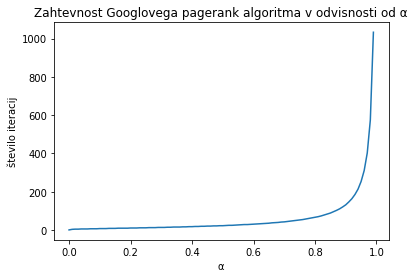

In [74]:
plt.plot(timings.keys(), iterations)
plt.xlabel('α')
plt.ylabel('število iteracij')
plt.title('Zahtevnost Googlovega pagerank algoritma v odvisnosti od α')
plt.savefig('Pagerank_alpha.png')
plt.show()

In [85]:
#tolerance
timings2 = {}
d = [10**(-x) for x in range (1, 20)]
for tol in d:
    timings2[tol] = pagerank3(M_fb, 100000, tol, 0.85)

process finished after 7 iterations
time consumption: 3.9555262663843678 seconds
process finished after 20 iterations
time consumption: 2.9535706297847355 seconds
process finished after 34 iterations
time consumption: 3.9740703883771857 seconds
process finished after 48 iterations
time consumption: 5.272974453560892 seconds
process finished after 62 iterations
time consumption: 4.668574976832133 seconds
process finished after 76 iterations
time consumption: 3.5576959838244875 seconds
process finished after 89 iterations
time consumption: 3.737286544595918 seconds
process finished after 103 iterations
time consumption: 5.005633413717078 seconds
process finished after 117 iterations
time consumption: 7.759644008280702 seconds
process finished after 131 iterations
time consumption: 4.2641195636788325 seconds
process finished after 145 iterations
time consumption: 6.181614193482346 seconds
process finished after 159 iterations
time consumption: 8.975228460521066 seconds
process finished af

In [87]:
iterations2 = [i[1] for i in timings2.values()]

[7,
 20,
 34,
 48,
 62,
 76,
 89,
 103,
 117,
 131,
 145,
 159,
 173,
 187,
 201,
 215,
 259,
 309,
 338]

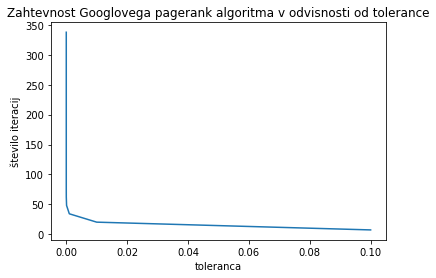

In [109]:
plt.plot(timings2.keys(), iterations2)
plt.xlabel('toleranca')
plt.ylabel('število iteracij')
plt.axis(xscale='lin')
plt.title('Zahtevnost Googlovega pagerank algoritma v odvisnosti od tolerance')
#plt.savefig('Pagerank_tolerance.png')
#plt.axis([10**(-20), 0.1, 0, None])
plt.show()